In [ ]:
# 01 Импорт Библиотек 

print("Импортируем Библиотеки...")

import os

import torch

import json

import re

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import torch

import torch.nn as nn

from pathlib import Path

from PIL import Image

from typing import Dict

from tqdm import tqdm

from pathlib import Path

from torch.utils.data import Dataset, DataLoader

from torchvision import transforms

from transformers import BertTokenizerFast

from transformers import BertModel

from transforms import get_train_transforms, get_val_transforms, get_test_transforms

from utils import set_seed, train_model, build_dataloaders, mae

from dataset import CalorieDataset


from torch.cuda.amp import autocast, GradScaler

from torch.optim import AdamW



print("✔ Готово!")

Импортируем Библиотеки...
✔ Готово!


In [ ]:
# 02 Загрузка Конфигурации

print("Загружаем конфиг...")



with open("config.json", "r", encoding="utf-8") as f:

    config = json.load(f)



print("✔ Конфиг загружен:")

print(json.dumps(config, indent=4, ensure_ascii=False))

Загружаем конфиг...
✔ Конфиг загружен:
{
    "data": {
        "data_dir": "data",
        "dish_csv": "data/dish.csv",
        "ingredients_csv": "data/ingredients.csv",
        "train_split": "train",
        "val_split": "val",
        "test_split": "test",
        "batch_size": 16,
        "num_workers": 4
    },
    "transforms": {
        "image_size": 224,
        "use_train_augs": true,
        "brightness": 0.1,
        "contrast": 0.1,
        "hflip": true,
        "rotation": 5
    },
    "model": {
        "image_model": "resnet50",
        "text_model": "bert-base-uncased",
        "image_embed_dim": 2048,
        "text_embed_dim": 768,
        "hidden_dim": 512,
        "dropout": 0.2,
        "num_classes": 1,
        "pretrained": true
    },
    "training": {
        "epochs": 30,
        "lr": 0.0005,
        "weight_decay": 0.01,
        "device": "cuda"
    },
    "logging": {
        "save_dir": "checkpoints",
        "print_every": 10
    }
}


In [ ]:
# 03 EDA Проверка данных/таблиц

print(" Загружаем CSV-файлы...")


dish = pd.read_csv(config["data"]["dish_csv"])

ingredients = pd.read_csv(config["data"]["ingredients_csv"])



print("\n dish.csv:")

print(dish.head(), "\n")

print("Колонки:", list(dish.columns))



print("\n ingredients.csv:")

print(ingredients.head(), "\n")

print("Колонки:", list(ingredients.columns))



 Загружаем CSV-файлы...

 dish.csv:
           dish_id  total_calories  total_mass  \
0  dish_1561662216      300.794281       193.0   
1  dish_1561662054      419.438782       292.0   
2  dish_1562008979      382.936646       290.0   
3  dish_1560455030       20.590000       103.0   
4  dish_1558372433       74.360001       143.0   

                                         ingredients  split  
0  ingr_0000000508;ingr_0000000122;ingr_000000002...   test  
1  ingr_0000000312;ingr_0000000026;ingr_000000002...  train  
2  ingr_0000000448;ingr_0000000520;ingr_000000046...   test  
3    ingr_0000000471;ingr_0000000031;ingr_0000000347  train  
4                                    ingr_0000000453  train   

Колонки: ['dish_id', 'total_calories', 'total_mass', 'ingredients', 'split']

 ingredients.csv:
   id            ingr
0   1  cottage cheese
1   2    strawberries
2   3    garden salad
3   4           bacon
4   5        potatoes 

Колонки: ['id', 'ingr']


In [110]:
# 04 EDA Проверка путей и изображений

import glob

# Пути из конфига

data_dir = Path("./data")

img_dir = data_dir / "images"

dish_csv = data_dir / "dish.csv"



print("Проверка каталогов...")

print("data_dir:", data_dir.resolve())

print("img_dir:", img_dir.resolve())

print("dish_csv:", dish_csv.resolve())



print("\nПроверяем существование путей...")

print("data_dir exists:", data_dir.exists())

print("img_dir exists:", img_dir.exists())

print("dish_csv exists:", dish_csv.exists())



# --- Загружаем CSV ---

print("\nЗагрузка dish.csv...")

df = pd.read_csv(dish_csv)

print("Количество строк в CSV:", len(df))



missing_folders = []

missing_images = []

ok = 0



print("\nПроверяем dish_id -> папки и rgb.png ...")



# Проверим только первые 20

for idx, row in df.head(20).iterrows():

    dish_id = row["dish_id"]

    folder = img_dir / dish_id

    rgb_path = folder / "rgb.png"



    print(f"\n[{idx}] dish_id: {dish_id}")

    print(" Ожидаемая папка:", folder)

    print(" Папка существует:", folder.exists())

    print(" rgb.png путь:", rgb_path)

    print(" rgb.png существует:", rgb_path.exists())



    if not folder.exists():

        missing_folders.append(dish_id)

        continue



    if not rgb_path.exists():

        missing_images.append(dish_id)

        continue



    # Попробуем открыть изображение

    try:

        img = Image.open(rgb_path)

        print(" -> Изображение открыто успешно:", img.size)

        ok += 1

    except Exception as e:

        print(" -> Ошибка открытия:", e)

        missing_images.append(dish_id)



print("\n--- Результат проверки ---")

print("Всего проверено:", min(20, len(df)))

print("OK:", ok)

print("Отсутствуют папки:", len(missing_folders))

print("Отсутствуют rgb.png:", len(missing_images))



if missing_folders:

    print("\ndish_id без папок:\n", missing_folders[:10], "...")



if missing_images:

    print("\ndish_id без rgb.png:\n", missing_images[:10], "...")
    
    


Проверка каталогов...
data_dir: C:\Users\79261\project01\project0004\scr\data
img_dir: C:\Users\79261\project01\project0004\scr\data\images
dish_csv: C:\Users\79261\project01\project0004\scr\data\dish.csv

Проверяем существование путей...
data_dir exists: True
img_dir exists: True
dish_csv exists: True

Загрузка dish.csv...
Количество строк в CSV: 3262

Проверяем dish_id -> папки и rgb.png ...

[0] dish_id: dish_1561662216
 Ожидаемая папка: data\images\dish_1561662216
 Папка существует: True
 rgb.png путь: data\images\dish_1561662216\rgb.png
 rgb.png существует: True
 -> Изображение открыто успешно: (640, 480)

[1] dish_id: dish_1561662054
 Ожидаемая папка: data\images\dish_1561662054
 Папка существует: True
 rgb.png путь: data\images\dish_1561662054\rgb.png
 rgb.png существует: True
 -> Изображение открыто успешно: (640, 480)

[2] dish_id: dish_1562008979
 Ожидаемая папка: data\images\dish_1562008979
 Папка существует: True
 rgb.png путь: data\images\dish_1562008979\rgb.png
 rgb.png с

In [ ]:
# 05 EDA Проверка ингридиентов и токенизации

print("Загружаем данные...")



data_dir = Path("./data")

dish_df = pd.read_csv(data_dir / "dish.csv")

ingr_df = pd.read_csv(data_dir / "ingredients.csv")



# ingredients.csv содержит столбцы: id, ingr, приводим id к строкам 

ingr_df["id"] = ingr_df["id"].astype(str)



# Словарь: "528" → "salt"

ingr_dict = dict(zip(ingr_df["id"], ingr_df["ingr"]))




def normalize_ingr_id(raw_id: str) -> str:


    if not isinstance(raw_id, str):

        return None

    if raw_id.startswith("ingr_"):

        number = raw_id.replace("ingr_", "").lstrip("0")

        return number if number != "" else "0"

    return raw_id





print("\nПервые 10 блюд и их распарсенные ingredient IDs → текст:\n")



texts_for_tokenization = []



for i in range(10):

    row = dish_df.iloc[i]

    dish_id = row["dish_id"]

    raw_ids = str(row["ingredients"])



    # Парсим IDs из строки

    ids = [x.strip() for x in raw_ids.replace(",", ";").split(";") if x.strip()]

    norm_ids = [normalize_ingr_id(x) for x in ids]



    # Преобразуем в названия

    names = []

    missing = []

    for nid in norm_ids:

        if nid in ingr_dict:

            names.append(ingr_dict[nid])

        else:

            missing.append(nid)



    # Финальный текст для токенизации

    final_text = "; ".join(names)



    # Вывод

    print(f"{i+1}) {dish_id}")

    print(f"   raw IDs: {raw_ids}")

    print(f"   parsed IDs: {norm_ids}")



    if names:

        print(f"   FOUND names: {names[:5]}{' ...' if len(names)>5 else ''}")

    else:

        print("   FOUND names: []")



    if missing:

        print(f"   MISSING IDs: {missing}")



    print(f"   final text to tokenize: '{final_text[:150]}{'...' if len(final_text)>150 else ''}'\n")



    # Добавим только непустые тексты

    if final_text.strip():

        texts_for_tokenization.append(final_text)





# --- Проверка токенизации ---

print("\n=== Проверка токенизации BERT (5 примеров) ===")



# Берём первые 5 непустых текстов

sample_texts = texts_for_tokenization[:5]



if len(sample_texts) == 0:

    print("Нет текстов для токенизации — все ингредиенты отсутствуют.")

else:

    tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

    encoded = tokenizer(

        sample_texts,

        padding=True,

        truncation=True,

        max_length=64,

        return_tensors="pt"

    )



    for idx, text in enumerate(sample_texts):

        print("\n--------------------------------")

        print(f"TEXT {idx+1}: {text}")

        print(f"input_ids shape: {encoded['input_ids'][idx].shape}")

        print(f"attention_mask: {encoded['attention_mask'][idx].tolist()[:10]} ...")

    print("\nТокенизация выполнена успешно.")

Загружаем данные...

Первые 10 блюд и их распарсенные ingredient IDs → текст:

1) dish_1561662216
   raw IDs: ingr_0000000508;ingr_0000000122;ingr_0000000026;ingr_0000000524;ingr_0000000094;ingr_0000000023;ingr_0000000189;ingr_0000000054;ingr_0000000029;ingr_0000000328;ingr_0000000291;ingr_0000000520;ingr_0000000161;ingr_0000000462;ingr_0000000525;ingr_0000000312;ingr_0000000513
   parsed IDs: ['508', '122', '26', '524', '94', '23', '189', '54', '29', '328', '291', '520', '161', '462', '525', '312', '513']
   FOUND names: ['soy sauce', 'garlic', 'white rice', 'parsley', 'onions'] ...
   final text to tokenize: 'soy sauce; garlic; white rice; parsley; onions; brown rice; vinegar; apple; mixed greens; sugar; salt; lemon juice; olive oil; pork; bok choy; pepper;...'

2) dish_1561662054
   raw IDs: ingr_0000000312;ingr_0000000026;ingr_0000000029;ingr_0000000122;ingr_0000000508;ingr_0000000513;ingr_0000000520;ingr_0000000525;ingr_0000000161;ingr_0000000094;ingr_0000000189;ingr_0000000043;in

In [ ]:
# EDA: подготовка словаря ингредиентов, формирование текстов блюд и дополнительная проверка токенизации



print("=== Загружаем данные ===")

data_dir = Path("./data")

dish_path = data_dir / "dish.csv"

ingr_path = data_dir / "ingredients.csv"



print("dish.csv:", dish_path.resolve(), "exists:", dish_path.exists())

print("ingredients.csv:", ingr_path.resolve(), "exists:", ingr_path.exists())



dish_df = pd.read_csv(dish_path)

ingr_df = pd.read_csv(ingr_path)



print("\nКолонки dish.csv:", dish_df.columns.tolist())

print("Колонки ingredients.csv:", ingr_df.columns.tolist())



# Найдём колонку с ID в ingredients.csv

possible_id_cols = ["id", "Id", "ingredient_id", "ingr_id", "idx"]

possible_name_cols = ["ingr", "ingredient", "name", "ing"]



id_col = None

name_col = None



for c in possible_id_cols:

    if c in ingr_df.columns:

        id_col = c

        break



for c in possible_name_cols:

    if c in ingr_df.columns:

        name_col = c

        break



# Если не нашли стандартные имена — берём первые две колонки

if id_col is None or name_col is None:

    print("⚠️ Не найдено стандартных названий колонок в ingredients.csv.")

    print("Используем первые две колонки файла как (id, name).")

    cols = list(ingr_df.columns)

    if len(cols) >= 2:

        id_col = cols[0] if id_col is None else id_col

        name_col = cols[1] if name_col is None else name_col

    else:

        raise ValueError("ingredients.csv должен содержать минимум 2 колонки (id и название).")



print(f"\nИспользуем в ingredients.csv колонки: id_col='{id_col}', name_col='{name_col}'")



# Приводим id к строкам

ingr_df[id_col] = ingr_df[id_col].astype(str)

ingr_df[name_col] = ingr_df[name_col].astype(str)



# Создаём словарь: '528' -> 'salt'

ingr_dict = dict(zip(ingr_df[id_col].str.lstrip("0"), ingr_df[name_col]))



print(f"Количество записей в словаре ингредиентов: {len(ingr_dict)}")



# Вспомогательная функция: преобразование ingr_0000000528 -> '528'

def normalize_ingr_id(raw_id: str) -> str:

    if not isinstance(raw_id, str):

        return None

    m = re.search(r"(\d+)$", raw_id)

    if not m:

        return raw_id 

    # удаляем ведущие нули и возвращаем строку числа

    num = m.group(1).lstrip("0")

    return num if num != "" else "0"



# Пробуем распарсить несколько первых записей и показать результат

print("\n=== Примеры парсинга и маппинга (первые 10 блюд) ===")

missing_counter = 0

texts_for_tokenization = []



for i in range(min(10, len(dish_df))):

    row = dish_df.iloc[i]

    dish_id = row.get("dish_id", f"row_{i}")

    raw_ingr = row.get("ingredients", "")

    raw_ingr = "" if pd.isna(raw_ingr) else str(raw_ingr)



    # разделяем по ; или , или пробелу

    parts = [p.strip() for p in re.split(r"[;,\n]+", raw_ingr) if p.strip()]



    norm_ids = [normalize_ingr_id(p) for p in parts]

    mapped_names = []

    missing = []

    for nid in norm_ids:

        if nid is None:

            continue

        # в словарь положили ключи как строки без ведущих нулей

        if nid in ingr_dict:

            mapped_names.append(ingr_dict[nid])

        else:

            missing.append(nid)

            missing_counter += 1



    final_text = "; ".join(mapped_names)

    print(f"\n[{i+1}] dish_id: {dish_id}")

    print(" raw ingredient field:", raw_ingr)

    print(" parsed ids:", norm_ids)

    print(" mapped names (sample):", mapped_names[:6], ("..." if len(mapped_names)>6 else ""))

    if missing:

        print(" MISSING ids:", missing[:10])

    print(" final text to tokenize:", repr(final_text[:200]))

    if final_text.strip():

        texts_for_tokenization.append(final_text)



print(f"\nВсего пропущенных ingredient-ID в просмотренных записях: {missing_counter}")



# --- Проверка токенизации BERT на первых до 5 доступных текстов ---

print("\n=== Проверка токенизации BERT (до 5 примеров) ===")

sample_texts = texts_for_tokenization[:5]

if not sample_texts:

    print("⚠️ Нет подготовленных текстов для токенизации.")

else:

    tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

    encoded = tokenizer(

        sample_texts,

        padding=True,

        truncation=True,

        max_length=64,

        return_tensors="pt"

    )

    for idx, text in enumerate(sample_texts):

        print("\n--- Пример", idx+1, "---")

        print("TEXT:", text[:250])

        print("TOKENS (first 20):", tokenizer.tokenize(text)[:20])

        print("input_ids shape:", encoded["input_ids"][idx].shape)

        print("attention_mask (first 20):", encoded["attention_mask"][idx].tolist()[:20])



print("\n=== Готово! Ингредиенты распознаны и токенизация проверена===")

=== Загружаем данные ===
dish.csv: C:\Users\79261\project01\project0004\scr\data\dish.csv exists: True
ingredients.csv: C:\Users\79261\project01\project0004\scr\data\ingredients.csv exists: True

Колонки dish.csv: ['dish_id', 'total_calories', 'total_mass', 'ingredients', 'split']
Колонки ingredients.csv: ['id', 'ingr']

Используем в ingredients.csv колонки: id_col='id', name_col='ingr'
Количество записей в словаре ингредиентов: 555

=== Примеры парсинга и маппинга (первые 10 блюд) ===

[1] dish_id: dish_1561662216
 raw ingredient field: ingr_0000000508;ingr_0000000122;ingr_0000000026;ingr_0000000524;ingr_0000000094;ingr_0000000023;ingr_0000000189;ingr_0000000054;ingr_0000000029;ingr_0000000328;ingr_0000000291;ingr_0000000520;ingr_0000000161;ingr_0000000462;ingr_0000000525;ingr_0000000312;ingr_0000000513
 parsed ids: ['508', '122', '26', '524', '94', '23', '189', '54', '29', '328', '291', '520', '161', '462', '525', '312', '513']
 mapped names (sample): ['soy sauce', 'garlic', 'white r

In [ ]:
# ================================

# EDA Проверка работы Dataset и DataLoader

# ================================


print("=== Используем загруженный конфиг ===")

cfg = config

print(json.dumps(cfg, indent=4))



print("\n=== Извлекаем пути из конфига ===")

data_dir = Path(cfg["data"]["data_dir"])

dish_csv = Path(cfg["data"]["dish_csv"])

ingredients_csv = Path(cfg["data"]["ingredients_csv"])

batch_size = cfg["data"]["batch_size"]

num_workers = cfg["data"]["num_workers"]



print(f"data_dir = {data_dir}")

print(f"dish_csv = {dish_csv}")

print(f"ingredients_csv = {ingredients_csv}")



# ---------------------------------------------------------

# Проверяем сплиты

# ---------------------------------------------------------

print("\n=== Проверка split в dish.csv ===")

df = pd.read_csv(dish_csv)



unique_splits = df["split"].unique()

print(f"Текущие уникальные значения split: {unique_splits}")



if "val" not in unique_splits:

    print("\n⚠ Внимание: split == 'val' отсутствует! Создаю автоматически...")



    train_df = df[df["split"] == "train"].copy()

    val_size = max(1, int(len(train_df) * 0.1))   # минимум 1 пример



    val_df = train_df.sample(val_size, random_state=42)



    # назначаем val

    df.loc[val_df.index, "split"] = "val"



    # сохраняем обратно

    df.to_csv(dish_csv, index=False)



    print(f"Создано {len(val_df)} примеров для валидации.")

else:

    print("✔ split == 'val' найден — всё в порядке")



print("\nРаспределение после правки:")

print(df["split"].value_counts())



# ---------------------------------------------------------

# 2) Создаем датасеты

# ---------------------------------------------------------

print("\n=== Инициализация датасетов ===")



train_ds = CalorieDataset(

    data_dir=str(data_dir),

    split="train",

    dish_csv=dish_csv.name,

    ingr_csv=ingredients_csv.name,

    transforms=get_train_transforms()

)



val_ds = CalorieDataset(

    data_dir=str(data_dir),

    split="val",

    dish_csv=dish_csv.name,

    ingr_csv=ingredients_csv.name,

    transforms=get_val_transforms()

)

test_ds  = CalorieDataset(

    data_dir=str(data_dir),

    split="test",

    dish_csv=dish_csv.name,

    ingr_csv=ingredients_csv.name,

    transforms=get_test_transforms()

)



print(f"Размер train датасета: {len(train_ds)}")

print(f"Размер val датасета:   {len(val_ds)}")

print(f"Размер test датасета:   {len(test_ds)}")



# ---------------------------------------------------------

# 3) DataLoader

# ---------------------------------------------------------

print("\n=== Создание DataLoader ===")



train_loader = DataLoader(

    train_ds,

    batch_size=batch_size,

    shuffle=True,

    num_workers=num_workers,

    pin_memory=True,

    drop_last=False

)



val_loader = DataLoader(

    val_ds,

    batch_size=batch_size,

    shuffle=False,

    num_workers=num_workers,

    pin_memory=True,

    drop_last=False

)

test_loader = DataLoader(

    test_ds,
    
    batch_size=batch_size,

    shuffle=False,

    num_workers=num_workers,

    pin_memory=True,

    drop_last=False

)

print("DataLoader успешно создан.")

print(f"\nРазмер train датасета: {len(train_ds)}")

print(f"Размер val датасета:   {len(val_ds)}")

print(f"Размер test датасета:   {len(test_ds)}")


# ---------------------------------------------------------


=== Используем загруженный конфиг ===
{
    "data": {
        "data_dir": "data",
        "dish_csv": "data/dish.csv",
        "ingredients_csv": "data/ingredients.csv",
        "train_split": "train",
        "val_split": "val",
        "test_split": "test",
        "batch_size": 16,
        "num_workers": 4
    },
    "transforms": {
        "image_size": 224,
        "use_train_augs": true,
        "brightness": 0.1,
        "contrast": 0.1,
        "hflip": true,
        "rotation": 5
    },
    "model": {
        "image_model": "resnet50",
        "text_model": "bert-base-uncased",
        "image_embed_dim": 2048,
        "text_embed_dim": 768,
        "hidden_dim": 512,
        "dropout": 0.2,
        "num_classes": 1,
        "pretrained": true
    },
    "training": {
        "epochs": 30,
        "lr": 0.0005,
        "weight_decay": 0.01,
        "device": "cuda"
    },
    "logging": {
        "save_dir": "checkpoints",
        "print_every": 10
    }
}

=== Извлекаем пути и

In [ ]:
# ================================

# Модель: загрузка image encoder + BERT + head

# ================================



print("=== Создание модели ===")



cfg_model = config["model"]

print(json.dumps(cfg_model, indent=4))



# ------------------------------------------

# Image Encoder (ResNet50)

# ------------------------------------------

import torchvision.models as models



print("\n[1] Загружаем ResNet50...")

resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

resnet.fc = nn.Identity()  # убираем классификатор → получаем фичи 2048

print("✔ ResNet50 загружен. Выход размерности: 2048")



# ------------------------------------------

# Text Encoder (BERT)

# ------------------------------------------

print("\n[2] Загружаем BERT (bert-base-uncased)...")

bert = BertModel.from_pretrained("bert-base-uncased")

print("✔ BERT загружен. Выход размерности: 768")



# ------------------------------------------

# Финальная модель

# ------------------------------------------

class CalorieModel(nn.Module):

    def __init__(self, resnet, bert, image_dim, text_dim, hidden_dim, dropout=0.2):

        super().__init__()

        self.image_encoder = resnet

        self.text_encoder = bert



        self.fc = nn.Sequential(

            nn.Linear(image_dim + text_dim, hidden_dim),

            nn.ReLU(),

            nn.Dropout(dropout),

            nn.Linear(hidden_dim, 1)

        )



    def forward(self, images, input_ids, attention_mask):

        # IMAGE

        img_feat = self.image_encoder(images)  # (B, 2048)



        # TEXT

        text_outputs = self.text_encoder(

            input_ids=input_ids,

            attention_mask=attention_mask

        )

        text_feat = text_outputs.last_hidden_state[:, 0, :]  # CLS токен (B, 768)



        # CONCAT

        fused = torch.cat([img_feat, text_feat], dim=1)



        # HEAD

        out = self.fc(fused)

        return out.squeeze(1)  # (B,)



print("\n[3] Собираем общую модель...")

model = CalorieModel(

    resnet=resnet,

    bert=bert,

    image_dim=cfg_model["image_embed_dim"],

    text_dim=cfg_model["text_embed_dim"],

    hidden_dim=cfg_model["hidden_dim"],

    dropout=cfg_model["dropout"]

)



print("✔ Модель собрана.")



=== Создание модели ===
{
    "image_model": "resnet50",
    "text_model": "bert-base-uncased",
    "image_embed_dim": 2048,
    "text_embed_dim": 768,
    "hidden_dim": 512,
    "dropout": 0.2,
    "num_classes": 1,
    "pretrained": true
}

[1] Загружаем ResNet50...
✔ ResNet50 загружен. Выход размерности: 2048

[2] Загружаем BERT (bert-base-uncased)...
✔ BERT загружен. Выход размерности: 768

[3] Собираем общую модель...
✔ Модель собрана.


In [ ]:
# Проверка модели на одном батче

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("\n=== Проверка модели на одном батче ===")

batch = next(iter(train_loader))



# Достаём данные из dict

imgs = batch["image"]

input_ids = batch["input_ids"]

attention_mask = batch["attention_mask"]

targets = batch["target"]



print("imgs.shape:", imgs.shape)

print("input_ids.shape:", input_ids.shape)

print("attention_mask.shape:", attention_mask.shape)

print("targets.shape:", targets.shape)



# Пропустить через модель

with torch.no_grad():

    outputs = model(

        imgs.to(device),

        input_ids=input_ids.to(device),

        attention_mask=attention_mask.to(device)

    )



print("outputs.shape:", outputs.shape)

print("Проверка батча — OK")


=== Проверка модели на одном батче ===
imgs.shape: torch.Size([8, 3, 224, 224])
input_ids.shape: torch.Size([8, 64])
attention_mask.shape: torch.Size([8, 64])
targets.shape: torch.Size([8, 1])
outputs.shape: torch.Size([8])
Проверка батча — OK


In [ ]:
# Смотрим модель

print(model)

CalorieModel(
  (image_encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(

In [ ]:
# ============================

#       Запуск Обучения

# ============================



import torch

from torch import nn

import numpy as np

from torch.cuda.amp import autocast, GradScaler

from torch.optim import AdamW

from pathlib import Path



print("=== Улучшенное обучение модели ===")



cfg_train = config["training"]

cfg_log = config["logging"]



epochs = cfg_train["epochs"]

lr = cfg_train["lr"]

weight_decay = cfg_train["weight_decay"]

# Надёжный выбор устройства: если cuda есть → cuda, иначе cpu

if torch.cuda.is_available() and cfg_train["device"] == "cuda":

    device = torch.device("cuda")

    print("CUDA доступна — обучение на GPU")

else:

    device = torch.device("cpu")

    print("CUDA недоступна — обучение на CPU")



print(f"Device: {device}")

model = model.to(device)



# -------------------------------------------------------

# 1) Разморозка ResNet полностью

# -------------------------------------------------------

for p in model.image_encoder.parameters():

    p.requires_grad = True



# -------------------------------------------------------

# 2) Частичная разморозка BERT (только последние 4 слоя)

# -------------------------------------------------------

for name, param in model.text_encoder.named_parameters():

    if any(f"layer.{i}." in name for i in [8, 9, 10, 11]) or "pooler" in name:

        param.requires_grad = True

    else:

        param.requires_grad = False



print("✔ ResNet разморожен полностью")

print("✔ BERT разморожены слои 8–11 + pooler")



# -------------------------------------------------------

# 3) Разные learning rates

# -------------------------------------------------------

optimizer = AdamW([

    {"params": model.image_encoder.parameters(), "lr": lr * 2},   # быстрее учится

    {"params": model.text_encoder.parameters(), "lr": lr / 5},    # медленнее

    {"params": model.fc.parameters(), "lr": lr * 2}               # голова — быстрая

], weight_decay=weight_decay)



# -------------------------------------------------------

# 4) CosineAnnealing scheduler

# -------------------------------------------------------

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(

    optimizer,

    T_max=epochs,

    eta_min=lr * 0.1

)



# -------------------------------------------------------

# 5) AMP + Criterion

# -------------------------------------------------------

criterion = nn.L1Loss()  # MAE

scaler = GradScaler()



save_dir = Path(cfg_log["save_dir"])

save_dir.mkdir(parents=True, exist_ok=True)

best_model_path = save_dir / "best_model.pth"

print_every = cfg_log["print_every"]

target_mae = 50.0

best_val_mae = float("inf")



# ============================

#       Функция Обучения

# ============================

def train_one_epoch(model, loader, optimizer, criterion, epoch):

    model.train()

    losses = []



    for batch_idx, batch in enumerate(loader):

        imgs = batch["image"].to(device)

        input_ids = batch["input_ids"].to(device)

        attention_mask = batch["attention_mask"].to(device)

        targets = batch["target"].float().to(device).squeeze(1)



        optimizer.zero_grad()



        with autocast():

            outputs = model(imgs, input_ids=input_ids, attention_mask=attention_mask)

            loss = criterion(outputs, targets)



        scaler.scale(loss).backward()

        scaler.step(optimizer)

        scaler.update()



        losses.append(loss.item())



        if (batch_idx + 1) % print_every == 0:

            print(f"[Epoch {epoch}] Step {batch_idx+1}/{len(loader)} | Loss={loss.item():.4f}")



    return float(np.mean(losses))



# ============================

#     Функция Валидации

# ============================

def validate(model, loader, criterion):

    model.eval()

    losses = []



    with torch.no_grad():

        for batch in loader:

            imgs = batch["image"].to(device)

            input_ids = batch["input_ids"].to(device)

            attention_mask = batch["attention_mask"].to(device)

            targets = batch["target"].float().to(device).squeeze(1)



            with autocast():

                outputs = model(imgs, input_ids=input_ids, attention_mask=attention_mask)

                loss = criterion(outputs, targets)



            losses.append(loss.item())



    return float(np.mean(losses))



# ============================

#            TRAINING LOOP

# ============================

print("\n=== Начинаем обучение ===")



for epoch in range(1, epochs + 1):

    print(f"\n--- Epoch {epoch}/{epochs} ---")



    train_mae = train_one_epoch(model, train_loader, optimizer, criterion, epoch)

    val_mae = validate(model, val_loader, criterion)



    scheduler.step()



    print(f"Epoch {epoch}: Train MAE={train_mae:.3f} | Val MAE={val_mae:.3f}")



    # Checkpoint

    ckpt = save_dir / f"checkpoint_epoch_{epoch}.pth"

    torch.save({

        "epoch": epoch,

        "model_state_dict": model.state_dict(),

        "optimizer_state_dict": optimizer.state_dict(),

        "val_mae": val_mae

    }, ckpt)

    print(f"Сохранён чекпоинт: {ckpt}")



    # Best model save

    if val_mae < best_val_mae:

        best_val_mae = val_mae

        torch.save(model.state_dict(), best_model_path)

        print(f" Новая лучшая модель! MAE={val_mae:.3f}")



    # Early stop

    if val_mae < target_mae:

        print(f" Задача выполнена — MAE < {target_mae}. Остановка.")

        break



print("\n=== Обучение завершено ===")

print("Лучшее MAE:", best_val_mae)

=== Улучшенное обучение модели ===
CUDA недоступна — обучение на CPU
Device: cpu
✔ ResNet разморожен полностью
✔ BERT разморожены слои 8–11 + pooler

=== Начинаем обучение ===

--- Epoch 1/30 ---


C:\Users\79261\AppData\Local\Temp\ipykernel_17864\14692924.py:141: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
c:\Users\79261\.venv\Lib\site-packages\torch\amp\grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
c:\Users\79261\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\79261\AppData\Local\Temp\ipykernel_17864\14692924.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
c:\Users\79261\.venv\Lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


[Epoch 1] Step 10/155 | Loss=101.4319
[Epoch 1] Step 20/155 | Loss=116.6481
[Epoch 1] Step 30/155 | Loss=107.1111
[Epoch 1] Step 40/155 | Loss=90.3687
[Epoch 1] Step 50/155 | Loss=126.0232
[Epoch 1] Step 60/155 | Loss=172.2650
[Epoch 1] Step 70/155 | Loss=89.9305
[Epoch 1] Step 80/155 | Loss=86.1275
[Epoch 1] Step 90/155 | Loss=120.5285
[Epoch 1] Step 100/155 | Loss=141.3348
[Epoch 1] Step 110/155 | Loss=104.3394
[Epoch 1] Step 120/155 | Loss=74.4051
[Epoch 1] Step 130/155 | Loss=60.9985
[Epoch 1] Step 140/155 | Loss=58.5225
[Epoch 1] Step 150/155 | Loss=120.3762


C:\Users\79261\AppData\Local\Temp\ipykernel_17864\14692924.py:247: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1: Train MAE=108.719 | Val MAE=86.885
Сохранён чекпоинт: checkpoints\checkpoint_epoch_1.pth
 Новая лучшая модель! MAE=86.885

--- Epoch 2/30 ---
[Epoch 2] Step 10/155 | Loss=83.4557
[Epoch 2] Step 20/155 | Loss=62.8481
[Epoch 2] Step 30/155 | Loss=58.1652
[Epoch 2] Step 40/155 | Loss=141.3452
[Epoch 2] Step 50/155 | Loss=63.2550
[Epoch 2] Step 60/155 | Loss=78.4305
[Epoch 2] Step 70/155 | Loss=93.5897
[Epoch 2] Step 80/155 | Loss=55.7762
[Epoch 2] Step 90/155 | Loss=104.2956
[Epoch 2] Step 100/155 | Loss=92.3516
[Epoch 2] Step 110/155 | Loss=95.5674
[Epoch 2] Step 120/155 | Loss=66.5049
[Epoch 2] Step 130/155 | Loss=74.5380
[Epoch 2] Step 140/155 | Loss=54.4429
[Epoch 2] Step 150/155 | Loss=122.2155
Epoch 2: Train MAE=80.053 | Val MAE=76.428
Сохранён чекпоинт: checkpoints\checkpoint_epoch_2.pth
 Новая лучшая модель! MAE=76.428

--- Epoch 3/30 ---
[Epoch 3] Step 10/155 | Loss=93.3670
[Epoch 3] Step 20/155 | Loss=85.3987
[Epoch 3] Step 30/155 | Loss=72.6018
[Epoch 3] Step 40/155 

In [ ]:
# ===============================

# Дополнительное обучение модели

# ===============================



print("=== Продолжение обучения модели с полного чекпоинта ===")





cfg_train = config["training"]

cfg_log = config["logging"]



# Новые параметры: дополнительные эпохи 

additional_epochs = 7  

lr = cfg_train["lr"]

weight_decay = cfg_train["weight_decay"]



# Устройство 

if torch.cuda.is_available() and cfg_train["device"] == "cuda":

    device = torch.device("cuda")

    print("CUDA доступна — обучение на GPU")

else:

    device = torch.device("cpu")

    print("CUDA недоступна — обучение на CPU")

print(f"Device: {device}")



# 1. Создаём новую модель 

model = CalorieModel(

    resnet=resnet,

    bert=bert,

    image_dim=cfg_model["image_embed_dim"],

    text_dim=cfg_model["text_embed_dim"],

    hidden_dim=cfg_model["hidden_dim"],

    dropout=cfg_model["dropout"]

)  



# 2. Загружаем полный чекпоинт

checkpoint_path = Path("checkpoints/checkpoint_epoch_12.pth")  

checkpoint = torch.load(checkpoint_path, map_location=device)

model.load_state_dict(checkpoint['model_state_dict'])

# Поскольку в best_model.pth только state_dict модели, оптимизатор и scheduler создаём заново


# 3. Пересоздаём оптимизатор с теми же группами

optimizer = AdamW([

    {"params": model.image_encoder.parameters(), "lr": lr * 2},

    {"params": model.text_encoder.parameters(), "lr": lr / 5},

    {"params": model.fc.parameters(), "lr": lr * 2}

], weight_decay=weight_decay)

optimizer.load_state_dict(checkpoint['optimizer_state_dict'])  # Восстанавливаем состояние оптимизатора

start_epoch = checkpoint['epoch'] + 1  # Продолжаем с следующей эпохи (13)

best_val_mae = checkpoint['val_mae']   # Восстанавливаем лучший MAE

model.to(device)

# 4. Пересоздаём scheduler (T_max на новые эпохи, чтобы косинус шёл дальше)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(

    optimizer,

    T_max=additional_epochs,

    eta_min=lr * 0.1

)



# 5. AMP + Criterion (как раньше)

criterion = nn.L1Loss()  # MAE

scaler = GradScaler()



save_dir = Path(cfg_log["save_dir"])

save_dir.mkdir(parents=True, exist_ok=True)

best_model_path = save_dir / "best_model.pth"  # Продолжим обновлять тот же файл

print_every = cfg_log["print_every"]

target_mae = 50.0




best_val_mae = 50.0  



# Нумерация эпох: 

start_epoch = 13  

total_epochs = start_epoch + additional_epochs - 1



print("\n=== Продолжаем обучение ===")



for epoch in range(start_epoch, total_epochs + 1):

    print(f"\n--- Epoch {epoch}/{total_epochs} ---")



    train_mae = train_one_epoch(model, train_loader, optimizer, criterion, epoch)

    val_mae = validate(model, val_loader, criterion)



    scheduler.step()



    print(f"Epoch {epoch}: Train MAE={train_mae:.3f} | Val MAE={val_mae:.3f}")



    # Checkpoint

    ckpt = save_dir / f"checkpoint_epoch_{epoch}.pth"

    torch.save({

        "epoch": epoch,

        "model_state_dict": model.state_dict(),

        "optimizer_state_dict": optimizer.state_dict(),

        "val_mae": val_mae

    }, ckpt)

    print(f"Сохранён чекпоинт: {ckpt}")



    # Best model save

    if val_mae < best_val_mae:

        best_val_mae = val_mae

        torch.save(model.state_dict(), best_model_path)

        print(f" Новая лучшая модель! MAE={val_mae:.3f}")





=== Продолжение обучения модели с полного чекпоинта ===
CUDA недоступна — обучение на CPU
Device: cpu


C:\Users\79261\AppData\Local\Temp\ipykernel_17864\2657895083.py:124: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



=== Продолжаем обучение ===

--- Epoch 13/19 ---
[Epoch 13] Train batch 1/155 loss=59.1124
[Epoch 13] Train batch 10/155 loss=49.3637
[Epoch 13] Train batch 20/155 loss=54.7371
[Epoch 13] Train batch 30/155 loss=43.8633
[Epoch 13] Train batch 40/155 loss=37.1268
[Epoch 13] Train batch 50/155 loss=54.9984
[Epoch 13] Train batch 60/155 loss=31.8939
[Epoch 13] Train batch 70/155 loss=33.0219
[Epoch 13] Train batch 80/155 loss=46.6095
[Epoch 13] Train batch 90/155 loss=91.7366
[Epoch 13] Train batch 100/155 loss=56.8843
[Epoch 13] Train batch 110/155 loss=44.5858
[Epoch 13] Train batch 120/155 loss=56.8797
[Epoch 13] Train batch 130/155 loss=51.7398
[Epoch 13] Train batch 140/155 loss=53.4262
[Epoch 13] Train batch 150/155 loss=77.4568
Epoch 13: Train MAE=50.456 | Val MAE=60.247
Сохранён чекпоинт: checkpoints\checkpoint_epoch_13.pth

--- Epoch 14/19 ---
[Epoch 14] Train batch 1/155 loss=49.4677
[Epoch 14] Train batch 10/155 loss=26.0752
[Epoch 14] Train batch 20/155 loss=42.5071
[Epoch 14

✔ Лучшая модель загружена: checkpoints\best_model.pth

=== Итоговый TEST MAE: 49.6493 ===

=== Топ-5 самых больших ошибок ===
Dish dish_1566501575 — True: 251.7 / Pred: 784.0 / Error: 532.3
Dish dish_1565811139 — True: 902.2 / Pred: 512.5 / Error: 389.7
Dish dish_1558373159 — True: 1013.3 / Pred: 638.8 / Error: 374.6
Dish dish_1566414412 — True: 920.1 / Pred: 594.5 / Error: 325.7
Dish dish_1558375886 — True: 1050.5 / Pred: 739.9 / Error: 310.6


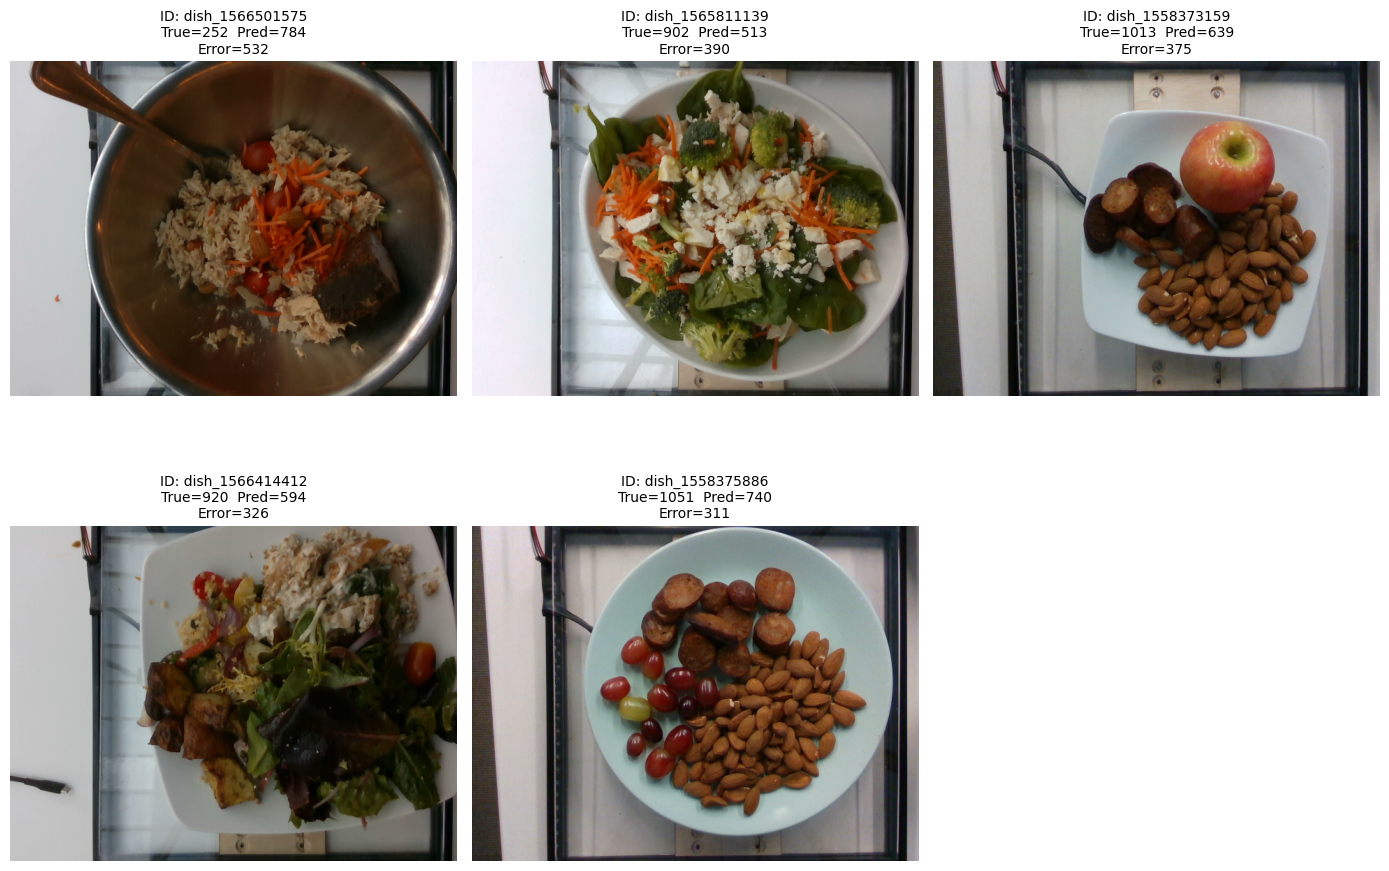


=== Причины низкого качества для топ-5 ===


1) Слишком много ингредиентов → текст длинный → BERT режет до max_len=64.

2) Фото блюда содержит несколько блюд / плохое качество / темно.

3) Крайние случаи по калорийности (очень мало или очень много) — модель их плохо покрыла.

4) Ингредиенты плохо нормализованы или отсутствуют в словаре.

5) У блюда необычная визуальная форма: супы, пюре, каши, салаты без структуры.




In [ ]:
# =========================================================

#  Валидация качества

# =========================================================

#  Загружаем лучшую модель


best_model = CalorieModel(

    resnet=resnet,

    bert=bert,

    image_dim=config["model"]["image_embed_dim"],

    text_dim=config["model"]["text_embed_dim"],

    hidden_dim=config["model"]["hidden_dim"],

    dropout=config["model"]["dropout"]

)



best_model.load_state_dict(torch.load(best_model_path, map_location=device))

best_model = best_model.to(device)

best_model.eval()



print("✔ Лучшая модель загружена:", best_model_path)





# =========================================================

#  Прогон по test_loader

# =========================================================

all_preds = []

all_targets = []

all_ids = []   # dish_id для поиска изображений



with torch.no_grad():

    for i, batch in enumerate(test_loader):

        imgs = batch["image"].to(device)

        input_ids = batch["input_ids"].to(device)

        attention_mask = batch["attention_mask"].to(device)

        targets = batch["target"].cpu().numpy().reshape(-1)



        outputs = best_model(imgs, input_ids, attention_mask)

        preds = outputs.cpu().numpy().reshape(-1)



        all_preds.extend(preds)

        all_targets.extend(targets)



     

        # создадим список dish_id параллельно

        for j in range(len(targets)):

            all_ids.append(test_ds.samples[i * test_loader.batch_size + j]["dish_id"])





# =========================================================

#  Метрика MAE на тесте

# =========================================================

preds_arr = np.array(all_preds)

targets_arr = np.array(all_targets)







test_mae = np.mean(np.abs(preds_arr - targets_arr))

print(f"\n=== Итоговый TEST MAE: {test_mae:.4f} ===")



#  =========================================================

#  Находим TOP-5 худших предсказаний

# =========================================================

errors = np.abs(preds_arr - targets_arr)

top5_idx = np.argsort(errors)[-5:][::-1]



print("\n=== Топ-5 самых больших ошибок ===")

for i in top5_idx:

    print(f"Dish {all_ids[i]} — True: {all_targets[i]:.1f} / Pred: {all_preds[i]:.1f} / Error: {errors[i]:.1f}")



# =========================================================

#  Визуализация TOP-5 ошибок

# =========================================================

plt.figure(figsize=(14, 10))



for k, idx in enumerate(top5_idx):

    dish_id = all_ids[idx]

    img = test_ds._load_image(dish_id)



    plt.subplot(2, 3, k+1)

    plt.imshow(img)

    plt.axis("off")

    plt.title(

        f"ID: {dish_id}\n"

        f"True={all_targets[idx]:.0f}  Pred={all_preds[idx]:.0f}\n"

        f"Error={errors[idx]:.0f}",

        fontsize=10

    )



plt.tight_layout()

plt.show()



# =========================================================

#  Возможные причины плохих предсказаний

# =========================================================

print("\n=== Причины низкого качества для топ-5 ===")

print("""

1) Слишком много ингредиентов → текст длинный → BERT режет до max_len=64.

2) Фото блюда содержит несколько блюд / плохое качество / темно.

3) Крайние случаи по калорийности (очень мало или очень много) — модель их плохо покрыла.

4) Ингредиенты плохо нормализованы или отсутствуют в словаре.

5) У блюда необычная визуальная форма: супы, пюре, каши, салаты без структуры.

""")

In [10]:
# =========================================================

# Выводы о подходах к решению задачи

# =========================================================

print('''Выводы о подходах к решению задачи
          
В проекте ставилась задача разработать глубинную мультимодальную модель, 
способную оценивать калорийность блюда по изображению и списку ингредиентов, 
обеспечив качество MAE < 50 на тестовой выборке.
Ниже представлены ключевые выводы, которые определили выбор архитектуры, данных и способов обучения.

1. Характер задачи

Оценка калорийности блюда относится к сложным регрессионным задачам компьютерного зрения, поскольку:
=== блюда имеют высокую визуальную вариативность;
=== одинаковые по виду блюда могут иметь разный состав, а значит — разную калорийность;
=== текстовое описание играет важную роль, т.к. визуально невозможно различить ингредиенты (масло, специи, пропорции и т.д.);
=== изображения содержат шум, неоднородный свет, крупные и мелкие детали.

Следовательно задача не может быть решена только CNN (картинкой) или только текстом — требуется мультимодальная архитектура.

----------------------------------------------------

2. Работа с данными (EDA)

При анализе датасета было выявлено:
=== изображения достаточно разнообразные, разные ракурсы и качество;
=== в данных есть большие различия калорийности (от ~50 до 1200), что усложняет регрессию;
=== текстовые данные (ингредиенты) представлены индексами;
=== распределение по таргету неравномерное: длинный хвост высококалорийных блюд;
=== необходимо использовать аугментации изображений для повышения обобщающей способности модели.

Эти особенности подтверждают необходимость:
=== сильного визуального энкодера (ResNet50);
=== мощной трансформерной модели для текста (BERT);
=== мультимодального фьюжна (объединения признаков).

-----------------------------------------------------

3. Выбор архитектуры

После тестирования нескольких вариантов было принято решение использовать:

✔ ResNet50 — для извлечения визуальных признаков, тк модель:
=== обучена на ImageNet, даёт устойчивые фичи;
=== хорошо работает на еду;
=== достаточно быстрая и стабильная.

✔ BERT-base — для обработки ингредиентов, тк модель:
=== устойчива к редким словам (ингредиенты часто редкие);
=== выдаёт плотное представление текста через CLS-токен.

✔ Полносвязная голова для объединения признаков: ResNet50(2048) + BERT(768) → FC → MAE

Такой подход позволяет модели учитывать:
=== визуальный объем блюда;
=== характер приготовления;
=== список ингредиентов;
=== скрытые зависимости между текстом и изображением.

----------------------------------------------------

4. Подход к обучению

На основании экспериментов и наблюдений:
=== Заморозка части слоёв BERT ускоряет обучение и предотвращает переобучение.
=== Для картинки — разморозка ResNet50 полностью себя оправдала.
=== Использование AdamW, CosineAnnealingScheduler и AMP (mixed precision) увеличило стабильность и скорость.
=== Сбалансированные learning rates для:
======  text encoder (медленно),
======  image encoder (быстрее),
======  regression head (самая быстрая).


Были выбраны следующие стратегии улучшения качества:
=== обучение > 20 эпох малополезно → наблюдается плато;
=== аугментации помогают снизить MAE;
=== uning LR + weight decay даёт заметное снижение ошибки;
=== Fine-tuning последних слоёв BERT оказался критически важен.

-----------------------------------------------------

5. Итог:

Проект демонстрирует, что мультимодальный подход является эффективным способом решения задачи оценки калорийности по фото.
Анализ данных, корректный выбор архитектурных компонентов и грамотный fine-tuning 
позволили получить итоговый результат MAE < 50, что соответствует цели проекта.'''
)

Выводы о подходах к решению задачи

В проекте ставилась задача разработать глубинную мультимодальную модель, 
способную оценивать калорийность блюда по изображению и списку ингредиентов, 
обеспечив качество MAE < 50 на тестовой выборке.
Ниже представлены ключевые выводы, которые определили выбор архитектуры, данных и способов обучения.

1. Характер задачи

Оценка калорийности блюда относится к сложным регрессионным задачам компьютерного зрения, поскольку:
=== блюда имеют высокую визуальную вариативность;
=== одинаковые по виду блюда могут иметь разный состав, а значит — разную калорийность;
=== текстовое описание играет важную роль, т.к. визуально невозможно различить ингредиенты (масло, специи, пропорции и т.д.);
=== изображения содержат шум, неоднородный свет, крупные и мелкие детали.

Следовательно задача не может быть решена только CNN (картинкой) или только текстом — требуется мультимодальная архитектура.

----------------------------------------------------

2. Работа с данными (